In [1]:
import os
import openai
import copy
import glob
import shutil
openai.api_key = os.getenv("OPENAI_API_KEY")
from IPython.display import display, Code, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
import time
import tiktoken

import numpy as np
import pandas as pd

import json
import io
import inspect
import requests
import re
import random
import string
import base64
import pymysql
import os.path
import matplotlib

1.文件夹操作辅助类函数

In [16]:
def create_or_get_folder(folder_name):
    """
    创建或获取文件夹
    """
    folder_path = os.path.join('./', folder_name)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    return folder_path

def create_or_get_doc(folder_path, doc_name):
    """
    创建或获取文件路径
    """
    file_path = os.path.join(folder_path, f'{doc_name}.md')
    if not os.path.exists(file_path):
        with open(file_path, 'w', encoding='utf-8') as file:
            file.write('') 
    doc_path = file_path
    
    return doc_path

def get_file_content(file_path):
    """
    获取本地文档的具体内容
    """
    with open(file_path, 'r', encoding='utf-8')as file:
        decoded_content = file.read()
    return decoded_content

def append_content_in_doc(folder_path, doc_path, dict_list):
    """
    创建文档，或为指定的文档增加内容
    """
    # 将字典列表转换为json字符串
    json_string = json.dumps(dict_list, indent=4, ensure_ascii=False)

    with open(doc_path, 'a', encoding='utf-8') as file:
        file.write(json_string)


def clear_content_in_doc(doc_path):
    """
    清空指定文档的全部内容
    """
    with open(doc_path, 'w') as file:
        pass   # 清空文件内容

def list_files_in_folder(folder_path):
    """
    列举当前文件夹的全部文件
    """
    file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path,f))]

    return file_names

def rename_doc_in_drive(doc_path, new_name):
    """
    修改制定的文档名称
    """
    # 分解原始路径以获取目录和拓展名
    directory, old_file_name = os.path.split(doc_path)
    extension = os.path.splitext(old_file_name)[1]
    #用新名称和原始拓展名组合新路径
    new_file_name = new_name + extension
    new_file_path = os.path.join(directory, new_file_name)

    # 重命名文件
    os.rename(doc_path, new_file_path)

    update_name = new_name

    return update_name

def delete_all_files_in_folder(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason:{e}')

In [25]:
class InterProject():
    """
    项目类，每个分析任务的基本对象\
    每个代码解释器必须说明所属项目，若无所属项目，则在代码解释器运行时会自动创建一个项目。\
    需要注意的是，项目不仅起到了说明和标注当前分析任务的作用，更关键的是，项目提供了每个分析任务的“长期记忆”。\
    即每个项目都有对应的文档，用于保存在分析和建模工作中的多轮对话内容。\
    """
    def __init__(self,
                 project_name,
                 doc_name,
                 folder_path = None,
                 doc_path = None,
                 doc_content = None):
        # 项目名称，即项目文件夹名称
        self.project_name = project_name
        # 项目某部分名称，即项目文件名称
        self.doc_name = doc_name 

        # 项目文件夹路径
        if folder_path == None:
            folder_path = create_or_get_folder(folder_name=project_name)
        self.folder_path = folder_path

        # 获取当前项目中的文件名称
        self.doc_list = list_files_in_folder(folder_path)

        # 项目文件路径
        if doc_path == None:
            doc_path = create_or_get_doc(folder_path=folder_path,
                                         doc_name=doc_name)
        self.doc_path = doc_path

        # 项目文件的具体内容，相当于多轮对话内容
        self.doc_content = doc_content
        # 若初始content不为空，则将其加入文档内
        if doc_content != None:
            append_content_in_doc(folder_path=folder_path,
                                  doc_path=doc_path,
                                  dict_list=doc_content)
    def get_doc_content(self):
        """
        根据项目某文件的文件路径，获取对应的文件内容
        """
        self.doc_content = get_file_content(file_path=self.doc_path)

        return self.doc_content

    def append_doc_content(self, content):
        """
        根据项目某文件的文件路径，追加文件内容
        """
        append_content_in_doc(folder_path = self.folder_path,
                              doc_path = self.doc_path,
                              dict_list=content)

    def clear_content(self):
        """
        清空某文件内的全部内容
        """
        clear_content_in_doc(doc_path=self.doc_path)

    def delete_all_files(self):
        """
        删除当前项目文件夹的全部文件
        """
        delete_all_files_in_folder(folder_path=self.folder_path)

    def update_doc_list(self):
        """
        更新当前项目文件夹内全部文件名称
        """
        self.doc_list = list_files_in_folder(self.folder_path)

    def rename_doc(self,new_name):
        """
        修改当前文件名称
        """
        self.doc_name = rename_doc_in_drive(doc_path=self.doc_path,
                                            new_name=new_name)

In [26]:
p1 = InterProject(project_name='测试项目',doc_name='测试文档',doc_content='测试内容1')

In [27]:
p1.folder_path

'./测试项目'

In [28]:
p1.doc_path

'./测试项目/测试文档.md'

In [29]:
p1.doc_name

'测试文档'

In [30]:
p1.doc_list

['测试文档.md']

In [31]:
p1.update_doc_list()

In [32]:
p1.doc_list

['测试文档.md']

In [34]:
p1.get_doc_content()

'"测试内容1""测试内容1"'

# 2.ChatMessages对话消息类

In [73]:
class ChatMessages():
    """
    Chatmessages类，用于创建Chat模型能够接收和解读messages对象，该对象是原始Chat模型接收的\
    messages对象的更高级表现形式，ChatMessages类对象将字典类型的list作为其属性之一，同时还能\
    区分系统消息和历史对话消息，并且能够自行计算当前对话的token量，并能够在append的同时删减\
    最早对话消息，从而能够更加顺畅的输入大模型并完成多轮对话需求。
    """

    def __init__(self,
                 system_content_list=[],
                 question='你好。',
                 tokens_thr=None,
                 project=None):
        self.system_content_list=system_content_list
        # 系统消息文档列表，相当于外部输入文档列表
        system_messages = []
        # 除系统消息外历史对话消息
        history_messages = []
        # 用于保存全部消息的list
        messages_all = []
        # 系统消息字符串
        system_content = ''
        # 历史消息字符串，此时为用户输入消息
        history_content = question
        # 系统消息+历史信息消息
        content_all = ''
        # 输入到messages中系统消息的个数，初始情况为0
        num_of_system_messages = 0
        # 全部消息的token数量
        all_tokens_count = 0

        encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

        # 将外部输入文档列表依次保存为系统消息
        if system_content_list != []:
            for content in system_content_list:
                system_messages.append({"role":"system", "content":content})
                # 同时进行全文档拼接
                system_content += content
            # 计算系统消息token
            system_tokens_count = len(encoding.encode(system_content))
            # 拼接系统消息
            messages_all += system_messages
            # 计算系统消息个数
            num_of_system_messages = len(system_content_list)

            # 若存在最大token数量限制
            if system_tokens_count >= tokens_thr:
                print("system_messages的tokens数量超出限制，当前系统消息将不会被输入模型，若有必要，请重新调整外部文档数量。")
                # 删除系统消息
                system_messages = []
                messages_all = []
                # 系统消息个数清零
                num_of_system_messages = 0
                # 系统消息token数清零
                system_tokens_count = 0

            all_tokens_count += system_tokens_count
        # 创建首次对话信息
        history_messages = [{"role":"user", "content":question}]
        # 创建全部消息列表
        messages_all += history_messages
        # 计算用户问题token
        user_tokens_count = len(encoding.encode(question))

        # 计算总token数
        all_tokens_count += user_tokens_count

        # 若存在最大token限制
        if tokens_thr != None:
            if all_tokens_count >= tokens_thr:
                print("当前用户问题的tokens数量超出限制，该消息无法被输入到模型中，请重新输入用户问题或调整外部文档数量。")
                # 同时清空系统消息和用户消息
                history_messages = []
                system_messages = []
                messages_all = []
                num_of_system_messages = 0
                all_tokens_count=0
        # 全部messages消息
        self.messages = messages_all
        # system_messages消息
        self.system_messages = system_messages
        # user_messages信息
        self.history_messages = history_messages
        # messages信息中全部content的token数量
        self.tokens_count = all_tokens_count
        # 系统消息数量
        self.num_of_system_messages = num_of_system_messages
        # 最大tokens数量阈值
        self.tokens_thr = tokens_thr
        # token数计算编码方式
        self.encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
        # message挂靠的项目
        self.project = project

    # 删除部分对话信息
    def messages_pop(self, manual=False, index=None):
        def reduce_tokens(index):
            drop_message = self.history_messages.pop(index)
            self.tokens_count -= len(self.encoding.encode(str(drop_message)))
        if self.tokens_thr is not None:
            while self.tokens_count >= self.tokens_thr:
                reduce_tokens(-1)
        if manual:
            if index is None:
                reduce_tokens(-1)
            elif 0 <= index <len(self.history_messages) or index == -1:
                reduce_tokens(index=index)
            else:
                raise ValueError("Invalid index value:{}".format(index))
            # 更新messages
            self.messages = self.system_messages + self.history_messages

    # 增加部分对话信息
    def messages_append(self, new_messages):

        # 若是一个单独字典，或json格式字典
        if type(new_messages) is dict or type(new_messages) is openai.openai_project.OpenAIObject:
            self.messages.append(new_messages)
            self.tokens_count += len(self.encoding.encode(str(new_messages)))
        # 若新消息也是ChatMessages对象
        elif isinstance(new_messages, ChatMessages):
            self.messages += new_messages.messages
            self.tokens_count += new_messags.tokens_count

        # 重新更新history_messages
        self.history_messages = self.messages[self.num_of_system_messages:]
        # 再执行pop，若有需要，则会删除部分历史消息
        self.messages_pop()
    
    # 复制消息
    def copy(self):
        # 创建一个新的ChatMessages对象，复制所有重要的属性
        system_content_str_list = [messages['content'] for messages in self.system_messages]
        new_obj = ChatMessages(
                system_content_list=copy.deepcopy(system_content_str_list), # 使用深复制来复制系统消息
                question=self.history_messages[0]["content"] if self.history_messages else '',
                tokens_thr=self.tokens_thr
        )
        # 复制任何其他需要复制的属性
        new_obj.history_messages = copy.deepcopy(self.history_messages) # 使用深复制来复制历史消息
        new_obj.messages = copy.deepcopy(self.messages)
        new_obj.tokens_count = self.tokens_count
        new_obj.num_of_system_messages = self.num_of_system_messages

        return new_obj

    # 增加系统消息
    def add_system_messages(self, new_system_content):
        system_content_list = self.system_content_list
        system_messages = []
        # 若是字符串，则将其转化为list
        if type(new_system_content) == str:
            new_system_content = [new_system_content]
        system_content_list.extend(new_system_content)
        new_system_content_str = ''
        for content in new_system_content:
            new_system_content_str += content
        new_token_count = len(self.encoding.encode(str(new_system_content_str)))
        self.tokens_count += new_token_count
        for message in system_content_list:
            system_messages.append({"role":"system", "content": message})
        self.system_messages = system_messages
        self.num_of_system_messages = len(system_content_list)
        self.messages = system_messages + self.history_messages

        # 再执行pop， 若有需要，则会删除部分历史信息
        self.messages_pop()

    # 删除系统消息
    def delete_system_messages(self):
        system_content_list = self.system_content_list
        if system_content_list != []:
            system_content_str = ''
            for content in system_content_list:
                system_content_str += content
            delete_token_count = len(self.encoding.encode(str(system_content_str)))
            self.tokens_count -= delete_token_count
            self.num_of_system_messages = 0
            self.system_content_list = []
            self.system_messages = []
            self.messages = self.history_messages

    # 清除对话消息中function消息
    def delete_function_messages(self):
        # 用于删除外部函数消息
        history_messages = self.history_messages
        # 从后向前迭代列表
        for index in range(len(history_messages) -1, -1, -1):
            message = history_messages[index]
            if message.get("function_call") or message.get("role") == "function":
                self.messages_pop(manual=True, index=index)

In [74]:
msg1 = ChatMessages()

In [75]:
msg1.system_messages

[]

In [76]:
msg1.history_messages

[{'role': 'user', 'content': '你好。'}]

In [77]:
msg1.messages_pop(manual=True)

In [78]:
msg1.history_messages

[]

# 3.Tools模块创建

In [79]:
def python_inter(py_code, g='globals()'):
    """
    专门用于执行非绘图类python代码，并获取最终查询或处理结果。若是设计绘图操作的python代码，则需要调用fig_inter函数来执行。
    :param py_code: 字符串形式的python代码
    :param g: g, 字符串形式变量，表示环境变量，无需设置，保持默认参数即可。
    :return: 代码运行结果
    """

    global_vars_before = set(g.keys())
    try:
        exec(py_code, g)
    except Exception as e:
        return f"代码执行时报错{e}"
    global_vars_after = set(g.keys())
    new_vars = global_vars_after - global_vars_before
    # 若存在新变量
    if new_vars:
        result = {var:g[var] for var in new_vars}
        return str(result)
    # 若不存在新变量，即有可能是代码表达式，也有可能代码对相同变量赋值
    else:
        try:
            # 尝试如果是表达式，则返回表达式运行结果
            return str(eval(py_code, g))
        # 若报错，则先测试是否是对相同变量重复赋值
        except Exception as e:
            try:
                exec(py_code, g)
                return "已经顺利运行代码"
            except Exception as e:
                pass
            # 若不是重复赋值，则报错
            return f"代码执行时报错{e}"

In [80]:
# 表达式语句运行测试
code_str1 = '2 + 5'
python_inter(py_code = code_str1, g=globals())

'7'

In [81]:
# 赋值语句运行测试
code_str1 = 'a = 1'
python_inter(py_code = code_str1, g=globals())

"{'a': 1}"

In [82]:
a

1

In [83]:
# 重复赋值语句运行测试
code_str1 = 'a = 10'
python_inter(py_code = code_str1, g=globals())

'已经顺利运行代码'

In [84]:
a

10

In [90]:
def fig_inter(py_code, fname, g='globals()', save_path='./'):
    """
    用于执行一段包含可视化绘图的Python代码，并最终获取一个图片类型对象保存到本地
    :param py_code: 字符串形式的Python代码，用于根据需求进行绘图，代码中必须包含Figure对象创建过程
    :param fname: py_code代码中创建的Figure变量名，以字符串形式表示。
    :param g: g，字符串形式变量，表示环境变量，无需设置，保持默认参数即可
    :param save_path: 图片保存的本地路径
    :return: 代码运行的最终结果
    """    
    # 若存在plt.show()，则删除
    py_code = py_code.replace('plt.show()', '')
    try:
        exec(py_code, g)            
    except Exception as e:
        return f"代码执行时报错{e}"
    
    # 根据图片名称，获取图片对象
    fig = g[fname]
    
    # 保存图片到本地
    try:
        # 确保保存路径以斜杠结尾
        if not save_path.endswith('/'):
            save_path += '/'
        fig.savefig(save_path + fname + '.png')
        res = f"已经成功运行代码，并已将代码创建的图片保存至本地路径：{save_path + fname + '.png'}"
        
    except Exception as e:
        res = f"保存图片时出错：{e}"
        
    return res


In [91]:
code_string = """
import matplotlib.pyplot as plt

# 数据
categories = ['Category 1', 'Category 2', 'Category 3', 'Category 4']
values = [4, 7, 1, 8]

# 创建 Figure 对象
fig, ax = plt.subplots()

# 在 Axes 对象 ax 上创建条形图
ax.bar(categories, values)

# 添加标题和标签
ax.set_title('Bar Chart Example')
ax.set_xlabel('Categories')
ax.set_ylabel('Values')

# 显示图表
plt.show()
"""

'已经成功运行代码，并已将代码创建的图片保存至本地路径：./fig.png'

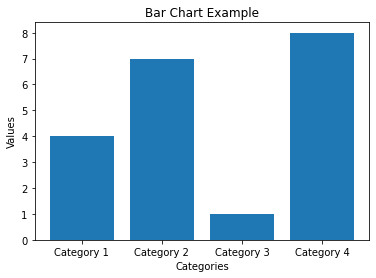

In [92]:
fig_inter(py_code=code_string, fname='fig', g=globals())